In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az # For visualization and loo
#needed for notebook
import nest_asyncio
nest_asyncio.apply()

## Source: https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html and https://github.com/stan-dev/example-models/tree/master/knitr/lotka-volterra

## Data

In [2]:
df=pd.read_csv('data/hudson-bay-lynx-hare.csv')
df.shape

(21, 3)

In [3]:
df.columns

Index(['Year', ' Lynx', ' Hare'], dtype='object')

/tmp/ipykernel_423/3971435561.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.Year)


[Text(-2.5, 0, '1900'),
 Text(0.0, 0, '1901'),
 Text(2.5, 0, '1902'),
 Text(5.0, 0, '1903'),
 Text(7.5, 0, '1904'),
 Text(10.0, 0, '1905'),
 Text(12.5, 0, '1906'),
 Text(15.0, 0, '1907'),
 Text(17.5, 0, '1908'),
 Text(20.0, 0, '1909'),
 Text(22.5, 0, '1910')]

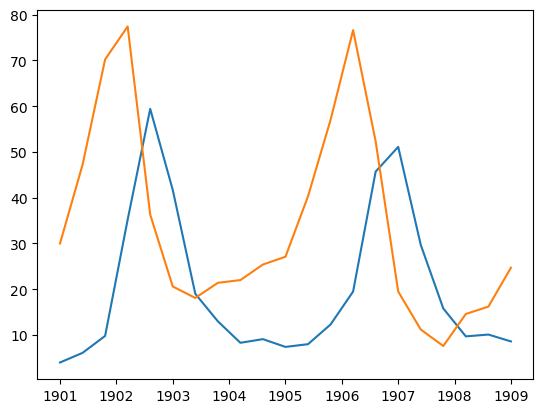

In [4]:
ax=df[' Lynx'].plot()
ax=df[' Hare'].plot(ax=ax)
ax.set_xticklabels(df.Year)

## Model code

In [5]:
model="""
    functions {
      array[] real dz_dt(real t, // time
                         array[] real z,
                         // system state {prey, predator}
                         array[] real theta, // parameters
                         array[] real x_r, // unused data
                         array[] int x_i) {
        real u = z[1];
        real v = z[2];

        real alpha = theta[1];
        real beta = theta[2];
        real gamma = theta[3];
        real delta = theta[4];

        real du_dt = (alpha - beta * v) * u;
        real dv_dt = (-gamma + delta * u) * v;
        return {du_dt, dv_dt};
      }
    }
    data {
      int<lower=0> N; // number of measurement times
      array[N] real ts; // measurement times > 0
      array[2] real y_init; // initial measured populations
      array[N, 2] real<lower=0> y; // measured populations
    }
    parameters {
      array[4] real<lower=0> theta; // { alpha, beta, gamma, delta }
      array[2] real<lower=0> z_init; // initial population
      array[2] real<lower=0> sigma; // measurement errors
    }
    transformed parameters {
      array[N, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                              rep_array(0.0, 0), rep_array(
                                              0, 0), 1e-5, 1e-3, 5e2);
    }
    model {
      theta[{1, 3}] ~ normal(1, 0.5);
      theta[{2, 4}] ~ normal(0.05, 0.05);
      sigma ~ lognormal(-1, 1);
      z_init ~ lognormal(log(10), 1);
      for (k in 1 : 2) {
        y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
        y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
      }
    }
    generated quantities {
      array[2] real y_init_rep;
      array[N, 2] real y_rep;
      for (k in 1 : 2) {
        y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
        for (n in 1 : N) {
          y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
        }
      }
    }
"""

In [6]:
N=df.shape[0]-1
ts=list(range(1, N+1))
y_init=[df[' Hare'][0], df[' Lynx'][0]]
y=df[[' Hare', ' Lynx']].iloc[1:,]

data={'N':N,
      'ts':ts,
      'y_init': y_init,
      'y':y.to_numpy()}

In [7]:
model=stan.build(program_code=model, data=data, random_seed=2324)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/dyo6nrk5/model_dyo6nrk5.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 8.0s
Building: 8.1s


/home/jovyan/.cache/httpstan/4.9.1/models/dyo6nrk5/model_dyo6nrk5.cpp: In instantiation of ‘void model_dyo6nrk5_namespace::model_dyo6nrk5::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/dyo6nrk5/model_dyo6nrk5.cpp:690:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/dyo6nrk5/model_dyo6nrk5.cpp:437:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  437 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 8.2s
Building: 8.3s


In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:168,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/dyo6nrk5/model_dyo6nrk5.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/lb_free.hpp: In instantiation of ‘auto stan::math::lb_free(std::vector<T1>, con

Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Buildin

Building: 19.8s, done.
Messages from stanc:
Warning in '/tmp/httpstan_ie5k6xnt/model_dyo6nrk5.stan', line 34, column 27: integrate_ode_rk45
    is deprecated and will be removed in Stan 3.0. Use ode_rk45 instead. 
    The new interface is slightly different, see:
    https://mc-stan.org/users/documentation/case-studies/convert_odes.html
Warning in '/tmp/httpstan_ie5k6xnt/model_dyo6nrk5.stan', line 40, column 35: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ie5k6xnt/model_dyo6nrk5.stan', line 40, column 29: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ie5k6xnt/model_dyo6nrk5.stan', line 34, column 46: The
    variable dz_dt may not have been assigned a value before its use.


In [8]:
fit = model.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

## Results

In [9]:
df_fit=fit.to_frame()
df_fit.shape

(4000, 97)

In [10]:
df_fit.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'theta.1', 'theta.2', 'theta.3', 'theta.4',
       'z_init.1', 'z_init.2', 'sigma.1', 'sigma.2', 'z.1.1', 'z.2.1', 'z.3.1',
       'z.4.1', 'z.5.1', 'z.6.1', 'z.7.1', 'z.8.1', 'z.9.1', 'z.10.1',
       'z.11.1', 'z.12.1', 'z.13.1', 'z.14.1', 'z.15.1', 'z.16.1', 'z.17.1',
       'z.18.1', 'z.19.1', 'z.20.1', 'z.1.2', 'z.2.2', 'z.3.2', 'z.4.2',
       'z.5.2', 'z.6.2', 'z.7.2', 'z.8.2', 'z.9.2', 'z.10.2', 'z.11.2',
       'z.12.2', 'z.13.2', 'z.14.2', 'z.15.2', 'z.16.2', 'z.17.2', 'z.18.2',
       'z.19.2', 'z.20.2', 'y_init_rep.1', 'y_init_rep.2', 'y_rep.1.1',
       'y_rep.2.1', 'y_rep.3.1', 'y_rep.4.1', 'y_rep.5.1', 'y_rep.6.1',
       'y_rep.7.1', 'y_rep.8.1', 'y_rep.9.1', 'y_rep.10.1', 'y_rep.11.1',
       'y_rep.12.1', 'y_rep.13.1', 'y_rep.14.1', 'y_rep.15.1', 'y_rep.16.1',
       'y_rep.17.1', 'y_rep.18.1', 'y_rep.19.1', 'y_rep.20.1', 'y_rep.1.2',
       'y_rep.2.2', 'y_r

In [11]:
az.summary(fit).head(8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.545,0.066,0.424,0.671,0.002,0.001,1177.0,1488.0,1.0
theta[1],0.028,0.004,0.020,0.036,0.000,0.000,1253.0,1563.0,1.0
theta[2],0.803,0.094,0.623,0.976,0.003,0.002,1148.0,1037.0,1.0
theta[3],0.024,0.004,0.018,0.031,0.000,0.000,1173.0,1093.0,1.0
z_init[0],34.021,2.859,28.806,39.337,0.052,0.037,3015.0,2810.0,1.0
z_init[1],5.935,0.531,4.892,6.868,0.011,0.008,2517.0,2382.0,1.0
sigma[0],0.247,0.041,0.180,0.330,0.001,0.001,2843.0,2327.0,1.0
sigma[1],0.251,0.043,0.178,0.332,0.001,0.001,3110.0,2768.0,1.0


## Plot results

In [12]:
z_init_draws=df_fit[[c for c in list(df_fit.columns) if 'z_init' in c]]
z_draws=df_fit[[c for c in list(df_fit.columns) if 'z.' in c]]
y_init_rep_draws=df_fit[[c for c in list(df_fit.columns) if 'y_init_rep' in c]]
y_rep_draws=df_fit[[c for c in list(df_fit.columns) if 'y_rep' in c]]

In [13]:
predicted_pelts = pd.DataFrame(np.nan, index=list(range(21)), columns=[0,1])
min_pelts = pd.DataFrame(np.nan, index=list(range(21)), columns=[0,1])
max_pelts = pd.DataFrame(np.nan, index=list(range(21)), columns=[0,1])
for k in range(2):
    predicted_pelts.iloc[0, k] = np.mean(y_init_rep_draws.iloc[:, k])
    min_pelts.iloc[0, k] = np.quantile(y_init_rep_draws.iloc[:, k], 0.25)
    max_pelts.iloc[0, k] = np.quantile(y_init_rep_draws.iloc[:, k], 0.75)
    
    n=20 #number of chuncks in df for each species
    data_animal=y_rep_draws.iloc[:,(0+n*k):(0+n*(1+k))]
    predicted_pelts.iloc[1:, k] = data_animal.mean(axis=0)
    min_pelts.iloc[1:,k]= np.quantile(data_animal, 0.25, axis=0)
    max_pelts.iloc[1:,k]= np.quantile(data_animal, 0.75, axis=0)

Text(0.5, 1.0, 'Hare prediction vs observation')

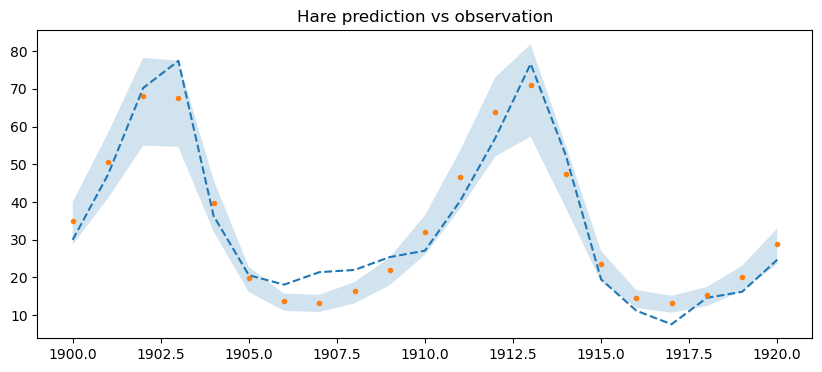

In [14]:
df_pred=pd.DataFrame({'hare_pred':predicted_pelts[0],
                      'lynx_pred':predicted_pelts[1],
                      'hare_min':min_pelts[0],
                      'hare_max':max_pelts[0],
                      'lynx_min':min_pelts[1],
                      'lynx_max':max_pelts[1],
                     'lynx_obs': df[' Lynx'],
                     'hare_obs': df[' Hare'],
                     'year': df.Year.astype(int)})

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_pred.year, df_pred.hare_obs, '--')
ax.plot(df_pred.year, df_pred.hare_pred, '.')
ax.fill_between(df_pred.year, df_pred.hare_min, df_pred.hare_max, alpha=0.2)
plt.title('Hare prediction vs observation')

Text(0.5, 1.0, 'Lynx prediction vs observation')

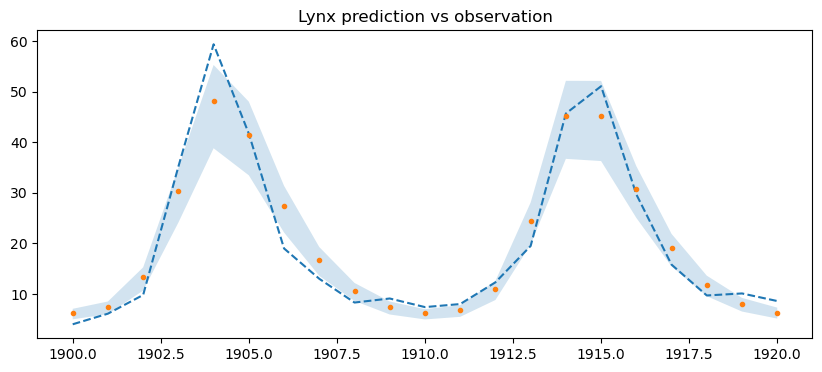

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_pred.year, df_pred.lynx_obs, '--')
ax.plot(df_pred.year, df_pred.lynx_pred, '.')
ax.fill_between(df_pred.year, df_pred.lynx_min, df_pred.lynx_max, alpha=0.2)
plt.title('Lynx prediction vs observation')

#### Plot of expected population orbit for one hundred draws from the posterior.  Each draw represents a different orbit determined by the differential equation system parameters.  Together they provide a sketch of posterior uncertainty for the *expected* population dynamics. If the ODE solutions were extracted per month rather than per year, the resulting plots would appear fairly smooth

In [16]:
z_draws.head()

parameters,z.1.1,z.2.1,z.3.1,z.4.1,z.5.1,z.6.1,z.7.1,z.8.1,z.9.1,z.10.1,...,z.11.2,z.12.2,z.13.2,z.14.2,z.15.2,z.16.2,z.17.2,z.18.2,z.19.2,z.20.2
draws,,,,,,,,,,,,,,,,,,,,,
0,46.481739,62.245908,66.449857,46.441207,25.489947,16.726651,14.827858,16.649377,21.692452,30.576815,...,7.505176,10.544289,19.253541,32.249681,34.634776,26.798338,18.393651,12.492448,8.985062,7.317554
1,47.811690,62.373103,60.093750,35.287012,18.655143,13.439272,13.299509,16.202886,22.166216,31.960445,...,7.520961,12.709751,27.206993,42.803420,38.310521,25.931829,16.346753,10.580900,7.554173,6.446512
2,39.040936,51.053644,54.478168,37.376170,19.951268,13.504533,12.601123,14.569119,18.938788,26.014566,...,6.518527,9.975574,21.428020,43.188410,48.036767,33.925823,20.589286,12.453422,8.175785,6.296930
3,52.985217,69.224008,65.984351,37.413968,19.171038,13.582938,13.318014,16.136444,22.023184,31.823652,...,6.265479,9.925619,21.600228,39.895607,40.360432,28.342996,17.837020,11.249301,7.612086,5.929872
4,51.921542,76.337900,80.620264,44.286649,19.674595,12.580216,11.974366,14.943172,21.849780,34.523113,...,7.653005,13.118622,29.293873,43.480885,36.516158,24.608771,15.846447,10.513367,7.666363,6.711892


In [17]:
n=20
draws_lynx=y_rep_draws.iloc[:,(0+n*0):(0+n*(1+0))]
draws_hare=y_rep_draws.iloc[:,(0+n*1):(0+n*(1+1))]

Text(0, 0.5, 'Hare pelts (thousands)')

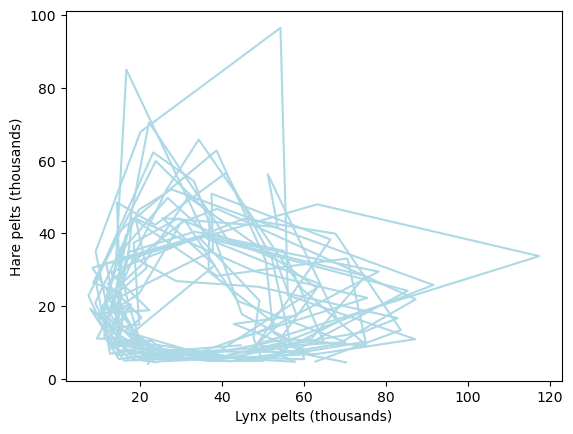

In [18]:
#Plot of expected pelt collection orbits for one hundred draws of system parameters from the posterior. 
#Even if plotted at more fine-grained time intervals, error would remove any apparent smoothness. 
#Extreme draws as seen here are typical when large values have high error on the multiplicative scale.
for i in range(12):
    plt.plot(draws_lynx.iloc[i, :100], draws_hare.iloc[i, :100], color='lightblue')
plt.xlabel('Lynx pelts (thousands)')
plt.ylabel('Hare pelts (thousands)')

Text(0, 0.5, 'Hare pelts (thousands)')

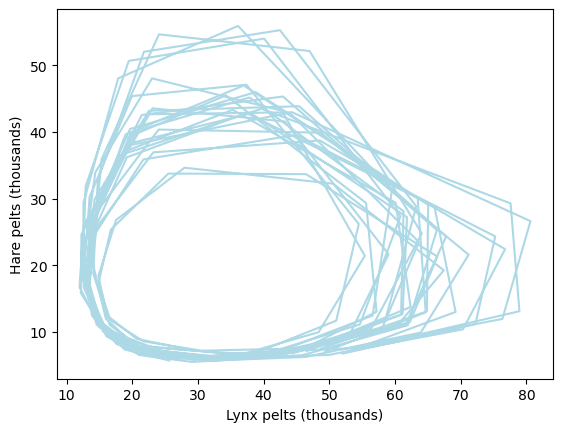

In [19]:
#Plot of expected population orbit for one hundred draws from the posterior. 
#Each draw represents a different orbit determined by the differential equation system parameters. 
#Together they provide a sketch of posterior uncertainty for the expected population dynamics. 
#If the ODE solutions were extracted per month rather than per year, the resulting plots would appear fairly smooth.
n=20
draws_z_lynx=z_draws.iloc[:,(0+n*0):(0+n*(1+0))]
draws_z_hare=z_draws.iloc[:,(0+n*1):(0+n*(1+1))]

for i in range(12):
    plt.plot(draws_z_lynx.iloc[i, :100], draws_z_hare.iloc[i, :100], color='lightblue')
plt.xlabel('Lynx pelts (thousands)')
plt.ylabel('Hare pelts (thousands)')